<a href="https://colab.research.google.com/github/codewithroger/Classification-of-emotion-/blob/main/Emotion_Recongnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training directory exists.
Validation directory exists. Contents:
['Engagement', 'Confusion', 'Boredom', 'Frustration']
Found 6600 images belonging to 4 classes.
Found 8041 images belonging to 4 classes.


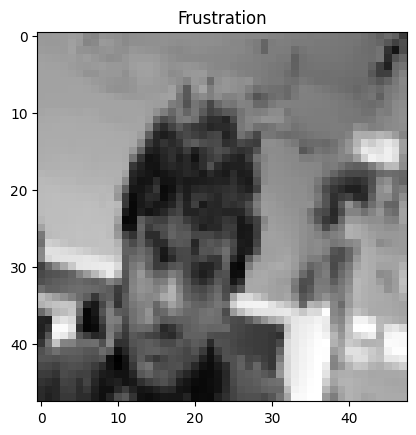

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from google.colab import drive
import os
from matplotlib import pyplot as plt
import numpy as np

IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

# Mount Google Drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/MyDrive/Classification/Frame20/Train'
validation_data_dir = '/content/drive/MyDrive/Classification/Frame20/Test'

# Verify directory paths
if not os.path.exists(train_data_dir):
    print(f"Training directory {train_data_dir} does not exist.")
else:
    print("Training directory exists.")

if not os.path.exists(validation_data_dir):
    print(f"Validation directory {validation_data_dir} does not exist.")
else:
    print("Validation directory exists. Contents:")
    print(os.listdir(validation_data_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Verify our generator by plotting a few faces and printing corresponding labels
class_labels = ['Engagement', 'Frustration', 'Boredom', 'Confusion']

img, label = train_generator.__next__()

import random

i = random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title(labl)
plt.show()

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

train_path = "/content/drive/MyDrive/Classification/Frame20/Train"
test_path = "/content/drive/MyDrive/Classification/Frame20/Test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

epochs = 1

history = model.fit(train_generator,
                    steps_per_epoch=num_train_imgs // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_test_imgs // batch_size)

model.save('emotion_detection_model_100epochs.h5')

# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Final Training Accuracy: {accuracy[-1]:.2f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}")

# Test the model
from keras.models import load_model

my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

# Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions = my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(test_labels, predictions))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

# Check results on a few select images
n = random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title("Original label is:" + orig_labl + " Predicted is: " + pred_labl)
plt.show()
